# DeViSE in Keras
Keras implementation of the Neural Network described in Andrea Frome and al. 2013 [DeViSE: A Deep Visual-Semantic Embedding Model](https://papers.nips.cc/paper/5204-devise-a-deep-visual-semantic-embedding-model).

More on word2vec check this [link](https://skymind.ai/wiki/word2vec).

<table class="tfo-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/dzlab/deepprojects/blob/master/classification/DeViSE_keras.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank"  href="https://github.com/dzlab/deepprojects/blob/master/classification/DeViSE_keras.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
!pip install nmslib

    100% |████████████████████████████████| 256kB 9.4MB/s 
    100% |████████████████████████████████| 153kB 32.1MB/s 
  Running setup.py bdist_wheel for nmslib ... - \ error
  Complete output from command /usr/bin/python3 -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-n3h60xnb/nmslib/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/pip-wheel-2joik9m9 --python-tag cp36:
  running bdist_wheel
  running build
  running build_ext
  creating tmp
  x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -c /tmp/tmpy0rb8b2w.cpp -o tmp/tmpy0rb8b2w.o -std=c++14
  x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python

In [3]:
!pip install git+https://github.com/facebookresearch/fastText.git

  Cloning https://github.com/facebookresearch/fastText.git to /tmp/pip-req-build-bo1mvmo3
  Running setup.py bdist_wheel for fasttext ... - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-296ru1p3/wheels/69/f8/19/7f0ab407c078795bc9f86e1f6381349254f86fd7d229902355
Successfully built fasttext


In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import preprocessing

In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
import io
import pathlib
import collections
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from random import randint
import pickle

In [0]:
import fastText as ft

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Data

In [0]:
path = pathlib.Path('.')
imagenet_path = path/'tiny-imagenet-200'
word2vec_path = path

### ImageNet
Download the [tiny](https://tiny-imagenet.herokuapp.com/) ImageNet dataset of size 236 MB, or the full dataset which is of size 155 GB and can be found [here](https://www.kaggle.com/c/imagenet-object-localization-challenge/data).

In [10]:
!curl -O http://cs231n.stanford.edu/tiny-imagenet-200.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  236M  100  236M    0     0  9127k      0  0:00:26  0:00:26 --:--:-- 8613k


In [0]:
!unzip -q tiny-imagenet-200.zip

In [0]:
!ls tiny-imagenet-200/

test  train  val  wnids.txt  words.txt


In [0]:
!ls tiny-imagenet-200/train/n01443537/images | head

n01443537_0.JPEG
n01443537_100.JPEG
n01443537_101.JPEG
n01443537_102.JPEG
n01443537_103.JPEG
n01443537_104.JPEG
n01443537_105.JPEG
n01443537_106.JPEG
n01443537_107.JPEG
n01443537_108.JPEG


In [0]:
!head tiny-imagenet-200/words.txt

n00001740	entity
n00001930	physical entity
n00002137	abstraction, abstract entity
n00002452	thing
n00002684	object, physical object
n00003553	whole, unit
n00003993	congener
n00004258	living thing, animate thing
n00004475	organism, being
n00005787	benthos


In [0]:
!head tiny-imagenet-200/wnids.txt

n02124075
n04067472
n04540053
n04099969
n07749582
n01641577
n02802426
n09246464
n07920052
n03970156


In [0]:
!wc -l tiny-imagenet-200/words.txt

82114 tiny-imagenet-200/words.txt


In [0]:
!wc -l tiny-imagenet-200/wnids.txt

200 tiny-imagenet-200/wnids.txt


### Word2Vec

#### Download word2vec
Download a decent [word2vec](https://skymind.ai/wiki/word2vec) representation like Facebook's [FastText](https://fasttext.cc/docs/en/english-vectors.html).

In [0]:
!curl -O https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  650M  100  650M    0     0  52.8M      0  0:00:12  0:00:12 --:--:-- 53.8M


In [0]:
!unzip -q wiki-news-300d-1M.vec.zip

In [13]:
!curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9877M  100 9877M    0     0  29.6M      0  0:05:33  0:05:33 --:--:-- 12.4M


In [14]:
!unzip wiki.en.zip

Archive:  wiki.en.zip
  inflating: wiki.en.vec             
  inflating: wiki.en.bin             


In [0]:
!head wiki.en.vec

#### Load the word vectors

In [0]:
# load the word2vec representations into numpy arrays
def load_vectors(fname):
    input = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    # read first line which contains number of tokens and vector dimension
    num, dim = map(int, input.readline().split())
    mean = np.zeros((dim), dtype=np.float32)
    # read line and convert tokens word2vec representation into numpy arrays
    data = {}
    for line in tqdm(input):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = [np.float32(i) for i in tokens[1:]]
        mean = mean + data[tokens[0]]
    # set the vector representation for unkown words with the mean vector
    mean = mean / num
    word2vec = data # word2vec = collections.defaultdict(lambda:mean, data)
    return word2vec, mean


word2vec, word2vec_mean = load_vectors(word2vec_path/'wiki.en.vec') # 'wiki-news-300d-1M.vec'

In [0]:
en_vecs = ft.load_model('wiki.en.bin')

In [0]:
def get_vecs(lang, ft_vecs):
    vecd = {w:ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
    pickle.dump(vecd, open(PATH/f'wiki.{lang}.pkl','wb'))
    return vecd

In [0]:
word2vec = get_vecs('en', en_vecs)

In [0]:
word2vec = pickle.load(open(path/'wiki.en.pkl','rb'))

#### Play with word2vec
Get the vector for few words and check the correlation coefficents between each of them

In [0]:
boat_vec   = en_vecs.get_word_vector('boat')   # word2vec['boat']
plane_vec  = en_vecs.get_word_vector('plane')  # word2vec['plane']
orange_vec = en_vecs.get_word_vector('orange') # word2vec['orange']
slug_vec   = en_vecs.get_word_vector('slug')   # word2vec['slug']

In [0]:
np.corrcoef(boat_vec, plane_vec)

array([[1.        , 0.36585215],
       [0.36585215, 1.        ]])

In [0]:
np.corrcoef(boat_vec, orange_vec)

array([[1.        , 0.05555721],
       [0.05555721, 1.        ]])

In [0]:
np.corrcoef(boat_vec, slug_vec)

array([[1.        , 0.13622368],
       [0.13622368, 1.        ]])

### ImageNet / Word2Vec mapping
Map imagenet classes (with their [synset](https://wordnet.princeton.edu/) repsentation) to their word2vec representation

In [0]:
def load_wordnet(fname, delimeter=' ', synset_idx=0, word_idx=1):
    input = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    syn2word, word2syn = {}, {}
    for line in tqdm(input):
        tokens = line.rstrip().split(delimeter)
        synset = tokens[synset_idx]
        word = tokens[word_idx].lower() # clean words like Arabian_camel
        # synset to word
        syn2word[synset] = word
        # word to synset
        word2syn[word] = synset
    return syn2word, word2syn

In [0]:
syn2word, word2syn = load_wordnet(imagenet_path/'words.txt', '\t') # 1k

82115it [00:00, 583919.98it/s]


read the synset ids for the training images

In [0]:
classes = [id.rstrip() for id in open(imagenet_path/'wnids.txt')]

In [0]:
classes[2], syn2word[classes[2]], classes[100], syn2word[classes[100]]

('n04540053', 'volleyball', 'n01945685', 'slug')

In [0]:
#np.corrcoef(word2vec[syn2word[classes[2]]], word2vec[syn2word[classes[100]]])
np.corrcoef(en_vecs.get_word_vector(syn2word[classes[2]]), en_vecs.get_word_vector(syn2word[classes[100]]))


array([[1.        , 0.06198629],
       [0.06198629, 1.        ]])

Check that we have a proper word2vec for each class

In [0]:
columns = ['id', 'word', 'vec']
data = {'id': [], 'word': [], 'vec': []}
for id in classes:
    data['id'].append(id)
    data['word'].append(syn2word[id])
    vec = en_vecs.get_word_vector(syn2word[id]) # vec = word2vec[syn2word[id]]
    data['vec'].append(vec[:5])
    
df = pd.DataFrame(data, columns=columns); df.head()

,id,word,vec
0,n02124075,egyptian cat,"[-0.11279647, -0.3181379, -0.0883948, 0.349539..."
1,n04067472,reel,"[0.18303585, 0.14932676, 0.022818606, -0.06660..."
2,n04540053,volleyball,"[-0.2620757, -0.30378416, -0.13442308, 0.26566..."
3,n04099969,"rocking chair, rocker","[0.09362481, -0.08155703, -0.11237239, 0.18448..."
4,n07749582,lemon,"[-0.023942592, 0.3128347, -0.09558003, -0.3638..."


a lot of the class lables in this tiny imagenet dataset cannot be found in the FastText word2vecs. As an altertive, will you use the labels from the real ImageNet dataset

In [26]:
!curl -O https://gist.githubusercontent.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57/raw/aa66dd9dbf6b56649fa3fab83659b2acbf3cbfd1/map_clsloc.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24365  100 24365    0     0  93711      0 --:--:-- --:--:-- --:--:-- 93711


In [29]:
syn2word, word2syn = load_wordnet(path/'map_clsloc.txt', delimeter=' ', synset_idx=0, word_idx=2)

1000it [00:00, 263942.11it/s]


In [0]:
columns = ['id', 'word', 'vec']
data = {'id': [], 'word': [], 'vec': []}
for id in classes:
    data['id'].append(id)
    data['word'].append(syn2word[id])
    vec = en_vecs.get_word_vector(syn2word[id]) # vec = word2vec[syn2word[id]]
    data['vec'].append(vec[:5])
    
df = pd.DataFrame(data, columns=columns); df.head()

,id,word,vec
0,n02124075,egyptian_cat,"[-0.5116956, -0.7840087, 0.41434303, 0.9064755..."
1,n04067472,reel,"[0.18303585, 0.14932676, 0.022818606, -0.06660..."
2,n04540053,volleyball,"[-0.2620757, -0.30378416, -0.13442308, 0.26566..."
3,n04099969,rocking_chair,"[-0.18833405, -0.2974052, 0.081969775, 0.20793..."
4,n07749582,lemon,"[-0.023942592, 0.3128347, -0.09558003, -0.3638..."


same problem, a lot of the classes in the dataset just do not exist in word2vec, will try a new way for combined words. basically take the average of word2vec for each word of the composite word. E.g. w2v('arabian_camel') = (w2v('arabian') + w2v('camel'))/2

In [0]:
EN_WORDS = en_vecs.get_words()

In [0]:
def get_vec_by_word(word, vec_size=300):
    # if word is in w2v then return it's vector
    #if word in word2vec: return word2vec[word]
    if word in EN_WORDS:
        return en_vecs.get_word_vector(word)
    # otherwise take the average of vectors of each word in this comopsite word
    vec = np.zeros((vec_size), dtype=np.float32)
    words = word.split('_')
    # return the vectors mean if the word is composite of one item
    if len(words)==1:
        #return word2vec_mean
        return np.random.random((vec_size))
    for w in words:
        vec = vec + get_vec_by_word(w)
    return vec / len(words)

In [0]:
columns = ['id', 'word', 'vec']
data = {'id': [], 'word': [], 'vec': []}
for id in classes:
    data['id'].append(id)
    data['word'].append(syn2word[id])
    vec = en_vecs.get_word_vector(syn2word[id]) # vec = word2vec[syn2word[id]]
    data['vec'].append(vec[:5])
    
df = pd.DataFrame(data, columns=columns); df.head()

,id,word,vec
0,n02124075,egyptian_cat,"[-0.5116956, -0.7840087, 0.41434303, 0.9064755..."
1,n04067472,reel,"[0.18303585, 0.14932676, 0.022818606, -0.06660..."
2,n04540053,volleyball,"[-0.2620757, -0.30378416, -0.13442308, 0.26566..."
3,n04099969,rocking_chair,"[-0.18833405, -0.2974052, 0.081969775, 0.20793..."
4,n07749582,lemon,"[-0.023942592, 0.3128347, -0.09558003, -0.3638..."


## Model
ResNet-50 based model

In [0]:
batch_size = 64
classes_size = 300

### Data

In [0]:
class ImageGenerator(Sequence):
    """Generator for a sequence of Images"""
    def __init__(self, path, fnames, labels, classes_size, batch_size, image_size=(224, 224), shuffle=True):
        self.path = path
        self.image_size, self.batch_size = image_size, batch_size
        self.items, self.items_size = fnames, len(fnames)
        self.labels = labels
        self.classes_size = classes_size
        self.indexes = np.arange(self.items_size)
        self.shuffle= shuffle
        self.on_epoch_end()

    def load_urls_(self, indexes):
        """Load the urls of the images into a tensor"""
        # init target arrays
        images = np.zeros((self.batch_size, self.image_size[0], self.image_size[1], 3), dtype=np.float32)
        labels = np.zeros((self.batch_size, self.classes_size), dtype=np.float32)
        # Find list of urls in this batch
        urls = [self.path/self.items[k] for k in indexes]
        lbls = [self.labels[k] for k in indexes]
        for index, img_path in enumerate(urls):
            # read image from url
            img = preprocessing.image.load_img(img_path, target_size=self.image_size)
            img_data = preprocessing.image.img_to_array(img)
            # read the proper label
            lbl_data = lbls[index]
            # append data
            images[index, :] = img_data
            labels[index, :] = lbl_data
            
        return images, labels
        
    def on_epoch_end(self):
        """Rearrange the indexes after each epoch"""
        self.indexes = np.arange(self.items_size)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        """Number of batches per epoch"""
        return int(np.floor(self.items_size / self.batch_size))
    
    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data for the batch
        X, y = self.load_urls_(indexes)
        return X, y

A helper class for dealing with image datasets, gathers training/validation/test data into one place

In [0]:
def get_label_name_from_fname(self, fname):
    """Get the name of the image label from the filename"""
    return '_'.join(fname.split('_')[:-1]).lower()
    
def get_label_index_from_fname(self, fname):
    """Get the index of the label from the filename"""
    lbl_name = self.get_label_name_from_fname(fname)
    return self.classes.index(lbl_name)

# get the word from a given image filename
def get_label_from_fname(fname):
    fname = fname.split('/')
    if 'train' in fname:
        index = fname.index('train') + 1
        synset = fname[index]
        word = syn2word[synset]
        return word
    print('cannot find word for', fname)
    return None

# get the word2vec representation from a given image filename
def get_word2vec_from_fname(fname):
    fname = fname.split('/')
    if 'train' in fname:
        index = fname.index('train') + 1
        synset = fname[index]
        word = syn2word[synset]
        vec = get_vec_by_word(word)
        return vec    
    print('cannot find word2vec representation for', fname)
    return None

In [0]:
!head tiny-imagenet-200/val/val_annotations.txt

val_0.JPEG	n03444034	0	32	44	62
val_1.JPEG	n04067472	52	55	57	59
val_2.JPEG	n04070727	4	0	60	55
val_3.JPEG	n02808440	3	3	63	63
val_4.JPEG	n02808440	9	27	63	48
val_5.JPEG	n04399382	7	0	59	63
val_6.JPEG	n04179913	0	0	63	56
val_7.JPEG	n02823428	5	0	57	63
val_8.JPEG	n04146614	0	31	60	60
val_9.JPEG	n02226429	0	3	63	57


data bunch for gathering train/validation/test sets in one place

In [0]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)


class DataBunch():
    """An image data bunch"""
    def __init__(self, path, classes_size, train_gen, valid_gen, test_gen=None):
        self.path = path
        self.cls_size = classes_size
        self.train_gen = train_gen
        self.valid_gen = valid_gen
        self.test_gen = test_gen
    
    def show_bunch(self, get_title, rows=3, figsize=(7, 6), **kwargs):
        """Show a bunch of images from the dataset"""
        imspaths = np.random.choice(self.train_gen.items, 9)
        # '_'.join(p.split('_')[:-1]).lower()
        titles = [get_title(p) for p in imspaths]
        imspaths = [(path/p).as_posix() for p in imspaths]
        plots_from_files(imspaths, figsize, rows, titles)

    @property
    def c(self):
        return self.classes       
    @property
    def classes_size(self):
        return self.cls_size

#### training dataset

##### Load data

In [0]:
pattern = '*/images/*.JPEG'
# training set
train_fnames = [str(p) for p in tqdm((imagenet_path/'train').glob(pattern))]
train_labels = [get_word2vec_from_fname(str(p)) for p in tqdm((imagenet_path/'train').glob(pattern))]
# generator
train_gen = ImageGenerator(path, train_fnames, train_labels, classes_size, batch_size)
print('Training set has %d batches of size %d' % (len(train_gen), batch_size))

##### Store data for later use

In [0]:
import pickle

In [0]:
pickle.dump(train_fnames, open('/content/gdrive/My Drive/data/devise_train_fnames.pkl','wb'))
pickle.dump(train_labels, open('/content/gdrive/My Drive/data/devise_train_labels.pkl','wb'))

In [0]:
train_fnames = pickle.load(open('/content/gdrive/My Drive/data/devise_train_fnames.pkl','rb'))
train_labels = pickle.load(open('/content/gdrive/My Drive/data/devise_train_labels.pkl','rb'))

#### validation dataset

In [0]:
# validation set
valid_fnames = []
valid_labels = []
for line in open('tiny-imagenet-200/val/val_annotations.txt'):    
    fname, synset = line.split('\t')[:2]
    fname = (imagenet_path/'val/images')/fname
    valid_fnames.append(fname.as_posix())
    word = syn2word[synset]
    vec = get_vec_by_word(word)
    valid_labels.append(vec)
# generator
valid_gen = ImageGenerator(path, valid_fnames, valid_labels, classes_size, batch_size)
print('Validation set has %d batches of size %d' % (len(valid_gen), batch_size))

Validation set has 156 batches of size 64


#### testing dataset

In [0]:
test_fnames = [p for p in (imagenet_path/'test').glob('images/*.JPEG')]
test_gen = ImageGenerator(path, test_fnames, [], classes_size, batch_size)
print('Test set has %d batches of size %d' % (len(test_gen), batch_size))

Test set has 156 batches of size 64


#### databunch

In [0]:
# combine all datasets into a bunch
data = DataBunch(path, 300, train_gen, valid_gen, test_gen)

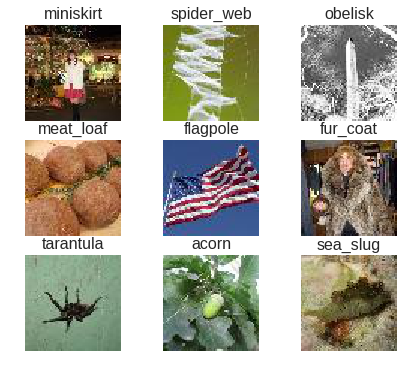

In [0]:
data.show_bunch(get_label_from_fname)

### Learner
A ResNet-50 based architecture

In [0]:
class Learner():
    """Base learner object"""
    def __init__(self):
        pass
            
    # freeze all layers of the model (from left to right)
    @classmethod
    def freeze(cls, model, limit=None):
        # handle negative indices
        if limit != None and limit < -1:
            limit = limit + len(model.layers) 
        # loop for all valid indices and mark the corresponding layer
        for index, layer in enumerate(model.layers):
            if limit != None and index > limit:
                break
            layer.trainable = False

    # unfreeze all layers of the model up to the given layer index (from right to left)
    @classmethod
    def unfreeze(cls, model, limit=None):
        # handle negative indices
        if limit != None and limit < -1:
            limit = limit + len(model.layers)
        for index, layer in enumerate(model.layers):
            if limit != None and index < limit:
                continue
            layer.trainable = True

In [0]:
class ImageClassificationLearner(Learner):
    """Image classification learner"""
    def __init__(self, data, archi, loss='categorical_crossentropy', metrics=['accuracy']):
        self.data = data
        self.model = self._create_model(archi)
        # compile the model to before training
        adam = Adam(lr=0.001, epsilon=0.01, decay=0.0001)
        self.model.compile(adam, loss, metrics)
        

    def _create_model(self, archi):
        model1 = ResNet50(weights='imagenet')
        # 1. freeze the original model up to the last layer we will keep
        Learner.freeze(model1, -3)
        # 2. create a new model that will be chained to the output of our base model
        x = model1.layers[-3].output          # shape should be (bs=None, 7, 7, 2048)
        x = Dropout(rate=0.3)(x)              # shape should be (bs=None, 7, 7, 2048)
        x = GlobalAveragePooling2D()(x)       # shape should be (bs=None, 2048)
        x = Dense(1024, activation='relu')(x) # shape should be (bs=None, 1024)
        x = BatchNormalization()(x)
        y = Dense(self.data.classes_size, activation='linear')(x) # shape should be (bs=None, num_champti
        model2 = Model(inputs=model1.input, outputs=y)
        return model2
        
    def fit(self, epochs=5):
        # fit the model using the previous generators
        train_gen = self.data.train_gen
        valid_gen = self.data.valid_gen
        history = self.model.fit_generator(generator=train_gen, validation_data=valid_gen, epochs=epochs, use_multiprocessing=True)
        return history

Loss function Cosine Distance

In [0]:
# the loss function as an inverse cosine distance
def cosine_loss(y, y_hat):
    # unit-normalize y and y_hat ()
    y = tf.math.l2_normalize(y, axis=1)
    y_hat = tf.math.l2_normalize(y_hat, axis=1)
    # cosine distance for normalized tensors
    loss = tf.losses.cosine_distance(y, y_hat, axis=1)
    return loss

### Training

In [0]:
learner = ImageClassificationLearner(data, loss=cosine_loss, archi='resnet50')

102858752/102853048 [==============================] - 2s 0us/step


In [0]:
history = learner.fit()

Epoch 1/5
1562/1562 [==============================] - 778s 498ms/step - loss: 0.6982 - acc: 0.1167 - val_loss: 0.4500 - val_acc: 0.1630
Epoch 2/5
1562/1562 [==============================] - 770s 493ms/step - loss: 0.2771 - acc: 0.4843 - val_loss: 0.3165 - val_acc: 0.4592
Epoch 3/5
1562/1562 [==============================] - 770s 493ms/step - loss: 0.2543 - acc: 0.5260 - val_loss: 0.2953 - val_acc: 0.4930
Epoch 4/5
1562/1562 [==============================] - 770s 493ms/step - loss: 0.2479 - acc: 0.5308 - val_loss: 0.2862 - val_acc: 0.5052
Epoch 5/5
1562/1562 [==============================] - 770s 493ms/step - loss: 0.2443 - acc: 0.5327 - val_loss: 0.2809 - val_acc: 0.5091


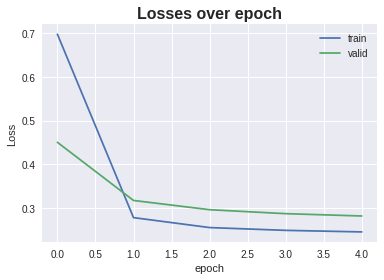

In [0]:
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="valid")

# Add legend
plt.legend(loc='top left')
# Add title and x, y labels
plt.title("Losses over epoch", fontsize=16, fontweight='bold')
#plt.suptitle("Random Walk Suptitle", fontsize=10)
plt.xlabel("epoch")
plt.ylabel("Loss")

plt.show()

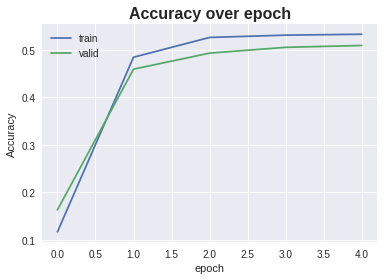

In [0]:
plt.plot(history.history['acc'], label="train")
plt.plot(history.history['val_acc'], label="valid")

# Add legend
plt.legend(loc='top left')
# Add title and x, y labels
plt.title("Accuracy over epoch", fontsize=16, fontweight='bold')
#plt.suptitle("Random Walk Suptitle", fontsize=10)
plt.xlabel("epoch")
plt.ylabel("Accuracy")

plt.show()

In [0]:
# Save the trained model in an HDF5 file
learner.model.save('devise.h5')

In [0]:
#!cp devise.h5 /content/gdrive/My\ Drive/data/models
!cp  /content/gdrive/My\ Drive/data/models/devise.h5 .

In [0]:
# Load the trained model
model = load_model('devise.h5', custom_objects={'cosine_loss': cosine_loss})

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Search

In [0]:
train_gen = None

In [0]:
import gc
gc.collect()

0

### Search: imagenet classes

run predictions on the training dataset to get word vector representations for the classes in the dataset

In [30]:
pattern = '*/images/*.JPEG'
fnames = [p.as_posix() for p in (imagenet_path/'train').glob(pattern)]
# parameters
image_size = (224, 224)
data_size  = len(fnames)
dimensions = 300
# place holders for X and y
y = np.zeros((data_size, dimensions), dtype=np.float32)
y_hat = np.zeros((data_size, dimensions), dtype=np.float32)
# read images and labels
for i, p in tqdm(enumerate(fnames)):
    # original label
    y[i, :] = get_word2vec_from_fname(p)
    # predicted label
    img = preprocessing.image.load_img(p, target_size=image_size)
    img_data = preprocessing.image.img_to_array(img)
    y_hat[i, :] = model.predict(img_data[None])

100000it [1:09:35, 23.95it/s]


In [31]:
y.shape, y_hat.shape

((100000, 300), (100000, 300))

In [32]:
!curl -O http://files.fast.ai/data/classids.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1700k  100 1700k    0     0  2526k      0 --:--:-- --:--:-- --:--:-- 2526k


In [0]:
!cat classids.txt | wc -l

82115


split the syn2word dictionnary into two list of synset and another one of vectors

In [0]:
syns_1k, words_1k = zip(*syn2word.items())
wvs_1k = [get_vec_by_word(word) for word in words_1k]

split english words in dictionnay (cannot really do this on Collaboratory it will crash)

In [0]:
words_all, wvs_all = zip(*word2vec.items())
len(syns_1k), len(words_1k), len(wvs_1k), len(words_all), len(wvs_all)

In [0]:
import nmslib

def create_index(a):
    # Initializes a new index
    index = nmslib.init(space='angulardist')
    # Add the datapoints to the index
    index.addDataPointBatch(a)
    # Create the index for querying
    index.createIndex()
    return index

def get_knns(index, vecs):
    """Get approximate K nearest neighbours for each vector in the list"""
    return zip(*index.knnQueryBatch(vecs, k=10, num_threads=4))

def get_knn(index, vec):
    """Get approximate K nearest neighbours of a vector."""
    return index.knnQuery(vec, k=10)

In [0]:
# this is too slow, avoiding it
#from sklearn.neighbors import NearestNeighbors
#wvs_index_sklearn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(wvs_all)
#distances, indices = wvs_index_sklearn.kneighbors(wvs_all)

### KNN on imagenet labels

create an index against the word vector representation in the class labels, then find the nearest words for what was predicted

In [0]:
wvs_index = create_index(wvs_1k) # nearest neighborhood on imageword2vec wvs

Get the 10 top nearest neighbours for each vector in y_hat (i.e. predicted word2vec for the test images)

#### on true labels

In [37]:
get_knn(wvs_index, y[0])

(array([364, 648, 885, 647, 452, 656, 363, 453, 458, 224], dtype=int32),
 array([0.        , 0.68119514, 0.7362414 , 0.9308378 , 0.9449915 ,
        0.9549681 , 0.9740239 , 0.9779966 , 0.98506117, 0.9892287 ],
       dtype=float32))

In [0]:
idxs, dists = get_knns(wvs_index, y)

In [39]:
idxs[100:102], idxs[10:12]

((array([364, 648, 885, 647, 452, 656, 363, 453, 458, 224], dtype=int32),
  array([364, 648, 885, 647, 452, 656, 363, 453, 458, 224], dtype=int32)),
 (array([364, 648, 885, 647, 452, 656, 363, 453, 458, 224], dtype=int32),
  array([364, 648, 885, 647, 452, 656, 363, 453, 458, 224], dtype=int32)))

have a look to the nearest neighbours for some vectors

In [0]:
offset = 300

In [42]:
idxs[offset:offset+10]

(array([364, 648, 885, 647, 452, 656, 363, 453, 458, 224], dtype=int32),
 array([364, 648, 885, 647, 452, 656, 363, 453, 458, 224], dtype=int32),
 array([364, 648, 885, 647, 452, 656, 363, 453, 458, 224], dtype=int32),
 array([364, 648, 885, 647, 452, 656, 363, 453, 458, 224], dtype=int32),
 array([364, 648, 885, 647, 452, 656, 363, 453, 458, 224], dtype=int32),
 array([364, 648, 885, 647, 452, 656, 363, 453, 458, 224], dtype=int32),
 array([364, 648, 885, 647, 452, 656, 363, 453, 458, 224], dtype=int32),
 array([364, 648, 885, 647, 452, 656, 363, 453, 458, 224], dtype=int32),
 array([364, 648, 885, 647, 452, 656, 363, 453, 458, 224], dtype=int32),
 array([364, 648, 885, 647, 452, 656, 363, 453, 458, 224], dtype=int32))

get the name of the top 3 neighbours for vectors between index start and start + 10

In [43]:
random_ids = [idxs[randint(0, len(idxs))] for i in range(10)]
[[words_1k[id] for id in ids[:3]] for ids in random_ids]

[['lakeside', 'beach_wagon', 'boathouse'],
 ['fly', 'dragonfly', 'plane'],
 ['altar', 'pedestal', 'vestment'],
 ['guacamole', 'chocolate_sauce', 'mashed_potato'],
 ['steel_arch_bridge', 'suspension_bridge', 'triumphal_arch'],
 ['spiny_lobster', 'anemone_fish', 'crayfish'],
 ['pizza', 'cheeseburger', 'restaurant'],
 ['hog', 'badger', 'wood_rabbit'],
 ['bison', 'wild_boar', 'bighorn'],
 ['plate', 'plate_rack', 'ladle']]

#### on predicted labels

In [0]:
idxs, dists = get_knns(wvs_index, y_hat)

In [45]:
random_ids = [idxs[randint(0, len(idxs))] for i in range(10)]
[[words_1k[id] for id in ids[:3]] for ids in random_ids]

[['vulture', 'arctic_fox', 'airship'],
 ['airship', 'vulture', 'arctic_fox'],
 ['arctic_fox', 'black_swan', 'vulture'],
 ['airship', 'vulture', 'indigo_bunting'],
 ['vulture', 'arctic_fox', 'indigo_bunting'],
 ['vulture', 'airship', 'grey_fox'],
 ['airship', 'arctic_fox', 'vulture'],
 ['indigo_bunting', 'vulture', 'arctic_fox'],
 ['airship', 'steel_arch_bridge', 'vulture'],
 ['airship', 'indigo_bunting', 'black_swan']]

these results are complete garbadge 

### KNN on wordnet labels

create an index against the word vector representation in FastText, then find the nearest words for what was predicted

In [0]:
wvs_index = create_index(wvs_all) # nearest neighborhood on imageword2vec wvs

In [0]:
idxs, dists = get_knns(wvs_index, y)

In [0]:
random_ids = [idxs[randint(0, len(idxs))] for i in range(10)]
[[words_all[id] for id in ids[:3]] for ids in random_ids]

[['orange', 'oranges', 'orang'],
 ['âksâr', 'август', 'ημερολόγιο'],
 ['âksâr', 'август', 'ημερολόγιο'],
 ['âksâr', 'август', 'ημερολόγιο'],
 ['acorn', 'corn', 'unicorn'],
 ['wooden', 'wedgwood', 'winwood'],
 ['âksâr', 'август', 'ημερολόγιο'],
 ['âksâr', 'август', 'ημερολόγιο'],
 ['âksâr', 'август', 'ημερολόγιο'],
 ['fountain', 'mountain', 'mountains']]

In [0]:
idxs, dists = get_knns(wvs_index, y_hat)

In [0]:
[[words_all[id] for id in ids[:3]] for ids in random_ids]

[['orange', 'oranges', 'orang'],
 ['âksâr', 'август', 'ημερολόγιο'],
 ['âksâr', 'август', 'ημερολόγιο'],
 ['âksâr', 'август', 'ημερολόγιο'],
 ['acorn', 'corn', 'unicorn'],
 ['wooden', 'wedgwood', 'winwood'],
 ['âksâr', 'август', 'ημερολόγιο'],
 ['âksâr', 'август', 'ημερολόγιο'],
 ['âksâr', 'август', 'ημερολόγιο'],
 ['fountain', 'mountain', 'mountains']]

### Search: Text to Image

helper functions to display search result

In [0]:
def ceildiv(a, b):
    return -(-a // b)

def show_img_old(fname, figsize=None, ax=None):
    img = preprocessing.image.load_img(fname, target_size=image_size)
    if not ax:
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.axis('off')
    return ax

def show_imgs_old(fnames, cols, figsize=None):
    fig,axes = plt.subplots(len(fnames)//cols, cols, figsize=figsize)
    for i,ax in enumerate(axes.flat):
        show_img(fnames[i], ax=ax)
    plt.tight_layout()
    plt.show()

def show_img(fname, figsize=None, ax=None):
    if not ax:
        fig,ax = plt.subplots(figsize=figsize)
    img = mpimg.imread(fname)
    ax.imshow(img)
    ax.axis('off')
    return ax

def show_imgs(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

Create an index on the predicted images then lookup for images with neighrest vector representation to the representation of an example word

In [0]:
wvs_index = create_index(y_hat) # nearest neighborhood on imageword2vec wvs

In [0]:
word = 'boat'
wv = en_vecs.get_word_vector(word) # word2vec[word]

In [0]:
idxs, dists = get_knn(wvs_index, wv)

In [50]:
imgs = [[fnames[id] for id in ids[:3]] for ids in [idxs]]; imgs

[['tiny-imagenet-200/train/n01742172/images/n01742172_32.JPEG',
  'tiny-imagenet-200/train/n02999410/images/n02999410_286.JPEG',
  'tiny-imagenet-200/train/n03804744/images/n03804744_261.JPEG']]

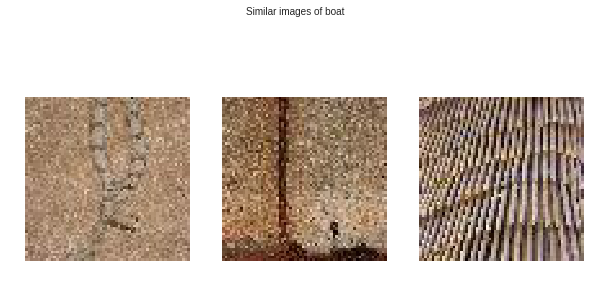

In [53]:
show_imgs(imgs[0], rows=1, maintitle='Similar images of '+word)

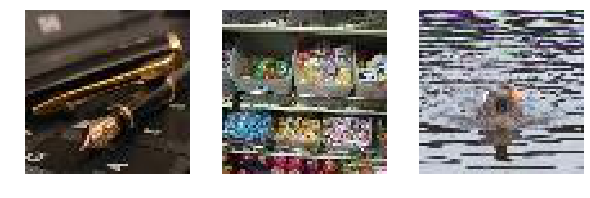

In [56]:
word = 'car'
wv = en_vecs.get_word_vector(word) # word2vec[word]
idxs, dists = get_knn(wvs_index, wv)
imgs = [[fnames[id] for id in ids[:3]] for ids in [idxs]]
show_imgs(imgs[0], rows=1)

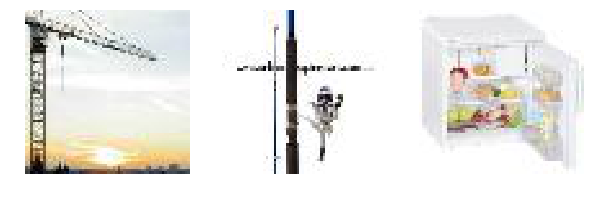

In [57]:
word = 'engine'
wv = en_vecs.get_word_vector(word) # word2vec[word]
idxs, dists = get_knn(wvs_index, wv)
imgs = [[fnames[id] for id in ids[:3]] for ids in [idxs]]
show_imgs(imgs[0], rows=1)

search for something between a boat and an engine

In [0]:
#vec = (np.array(word2vec['engine']) + np.array(word2vec['boat'])) / 2
vec = (np.array(en_vecs.get_word_vector('engine')) + np.array(en_vecs.get_word_vector('boat'))) / 2

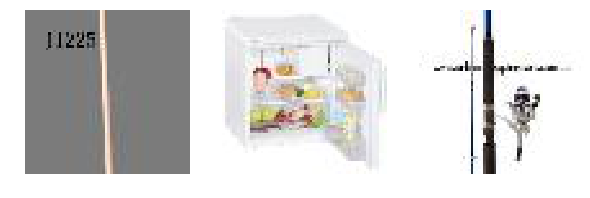

In [60]:
idxs, dists = get_knn(wvs_index, vec.tolist())
imgs = [[fnames[id] for id in ids[:3]] for ids in [idxs]]
show_imgs(imgs[0], rows=1)

### Search: Image to Image

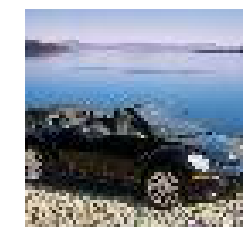

In [72]:
fname = imagenet_path/'test/images/test_104.JPEG'
show_img(fname)

In [0]:
img = preprocessing.image.load_img(fname, target_size=image_size)
img_data = preprocessing.image.img_to_array(img)
vec = model.predict(img_data[None])

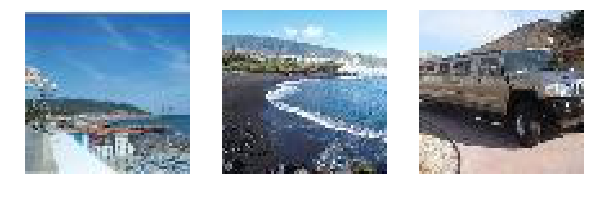

In [73]:
idxs, dists = get_knn(wvs_index, vec)
imgs = [[fnames[id] for id in ids[:3]] for ids in [idxs]]
show_imgs(imgs[0], rows=1)

Oh finally something meaningful, images with car and beaches!